In [29]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import learning modules
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.5)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", r2_score(y_true, y_pred))
    print("RMSE: ", (mean_squared_error(y_true, y_pred)) ** 0.5)

In [6]:
df = pd.read_csv('Data/210907_Essay_score_cleaned_2.csv')

In [7]:
cols = ['Grade', 'Major', 'Field']
for c in cols:
    df[c] = df[c].fillna('N/A')
df.Grade = df.Grade.astype(str)
df = df.drop(['Unnamed: 0', 'Code'], axis=1)

X = df.drop(['VST'], axis=1).copy()
y = df.VST.copy()

In [ ]:
scatterplots(columns = X.select_dtypes(include=np.number).columns, y_col = 'VST', data=df, ncol=4, figsize=(15,20))

In [9]:
X = pd.get_dummies(X, dtype='int64')
X.shape

(2600, 190)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(1950, 190) (650, 190) (1950,) (650,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [12]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
params = {
    'n_estimators': [int(n) for n in np.logspace(1,3,5)],
    'max_depth': [None, 10, 20, 30]
}
rf_grid_cv = GridSearchCV(rf, params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
print(rf_grid_cv.best_params_)
pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'max_depth': None, 'n_estimators': 1000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,18.935200,0.539090,1.412283,0.363523,None,1000,"{'max_depth': None, 'n_estimators': 1000}",0.791947,0.753622,0.812065,0.771341,0.780318,0.781859,0.019619,1
19,19.852418,1.886248,1.043160,0.662069,30,1000,"{'max_depth': 30, 'n_estimators': 1000}",0.791698,0.753738,0.811649,0.771360,0.780461,0.781781,0.019428,2
14,20.092331,0.648452,1.928352,0.775731,20,1000,"{'max_depth': 20, 'n_estimators': 1000}",0.790448,0.754355,0.811673,0.770948,0.780690,0.781623,0.019179,3
9,14.112157,0.234456,1.097717,0.371226,10,1000,"{'max_depth': 10, 'n_estimators': 1000}",0.789267,0.753953,0.810861,0.771438,0.779792,0.781062,0.018891,4
3,5.478655,0.866416,1.870169,0.308507,None,316,"{'max_depth': None, 'n_estimators': 316}",0.791974,0.751496,0.810119,0.772624,0.777819,0.780806,0.019590,5


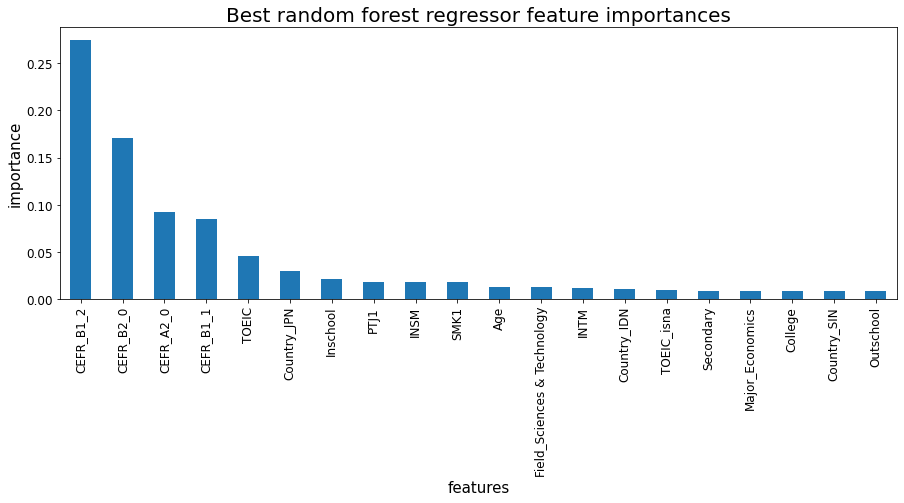

In [15]:
rf_best = rf_grid_cv.best_estimator_
rf_best.fit(X_train, y_train)

plt.subplots(figsize=(15, 5))
imps = rf_grid_cv.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:20]
rf_feat_imps.plot(kind='bar', fontsize=12)
plt.xlabel('features', fontsize=15)
plt.ylabel('importance', fontsize=15)
plt.title('Best random forest regressor feature importances', fontsize=20);

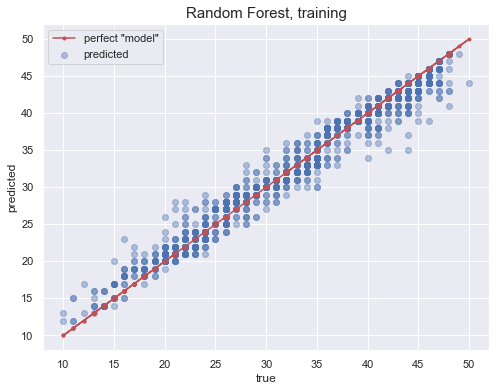

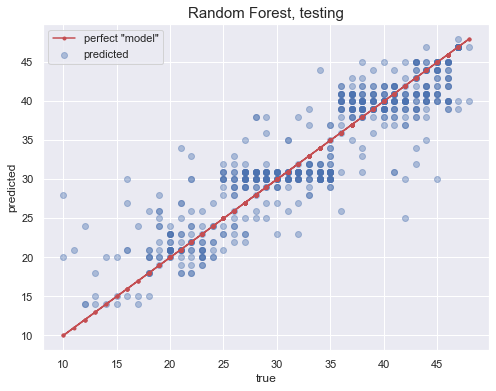

In [35]:
y_tr_rf_pred = np.round(rf_best.predict(X_train))
y_te_rf_pred = np.round(rf_best.predict(X_test))
pred_plot("Random Forest, training", y_train, y_tr_rf_pred)
pred_plot("Random Forest, testing", y_test, y_te_rf_pred)

In [36]:
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.8237407146771071
RMSE:  3.687817782917155


In [37]:
xg = XGBRegressor(objective='reg:linear', seed=42)
params = {
    'max_depth': range(1, 8),
    'n_estimators': [int(n) for n in np.logspace(start=1, stop=3, num=5)],
    'learning_rate': [n for n in np.logspace(start=-3, stop=0, num=4)]
}
xg_grid_cv = GridSearchCV(xg, param_grid=params, cv=10, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
print(xg_grid_cv.best_params_)
pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
97,3.210477,0.140430,0.008131,0.001479,0.1,6,100,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.824846,0.763523,0.717768,0.768385,0.825112,0.818574,0.789488,0.743950,0.701674,0.821262,0.777458,0.043561,1
54,25.101031,1.297930,0.010124,0.001756,0.01,4,1000,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.836125,0.750758,0.716366,0.769234,0.807562,0.818469,0.782580,0.740647,0.719564,0.816045,0.775735,0.040909,2
87,2.471804,0.051523,0.008379,0.001198,0.1,4,100,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.827047,0.753447,0.715210,0.769073,0.805187,0.818316,0.787700,0.737814,0.705588,0.818513,0.773789,0.042204,3
59,31.740977,1.250271,0.010344,0.002659,0.01,5,1000,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.824815,0.756830,0.699188,0.770910,0.809975,0.816475,0.785870,0.746021,0.698409,0.817567,0.772606,0.044831,4
92,2.732811,0.110373,0.007679,0.001002,0.1,5,100,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.820832,0.767419,0.708887,0.764511,0.812752,0.815327,0.785569,0.746693,0.689985,0.811861,0.772384,0.043728,5


[09:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


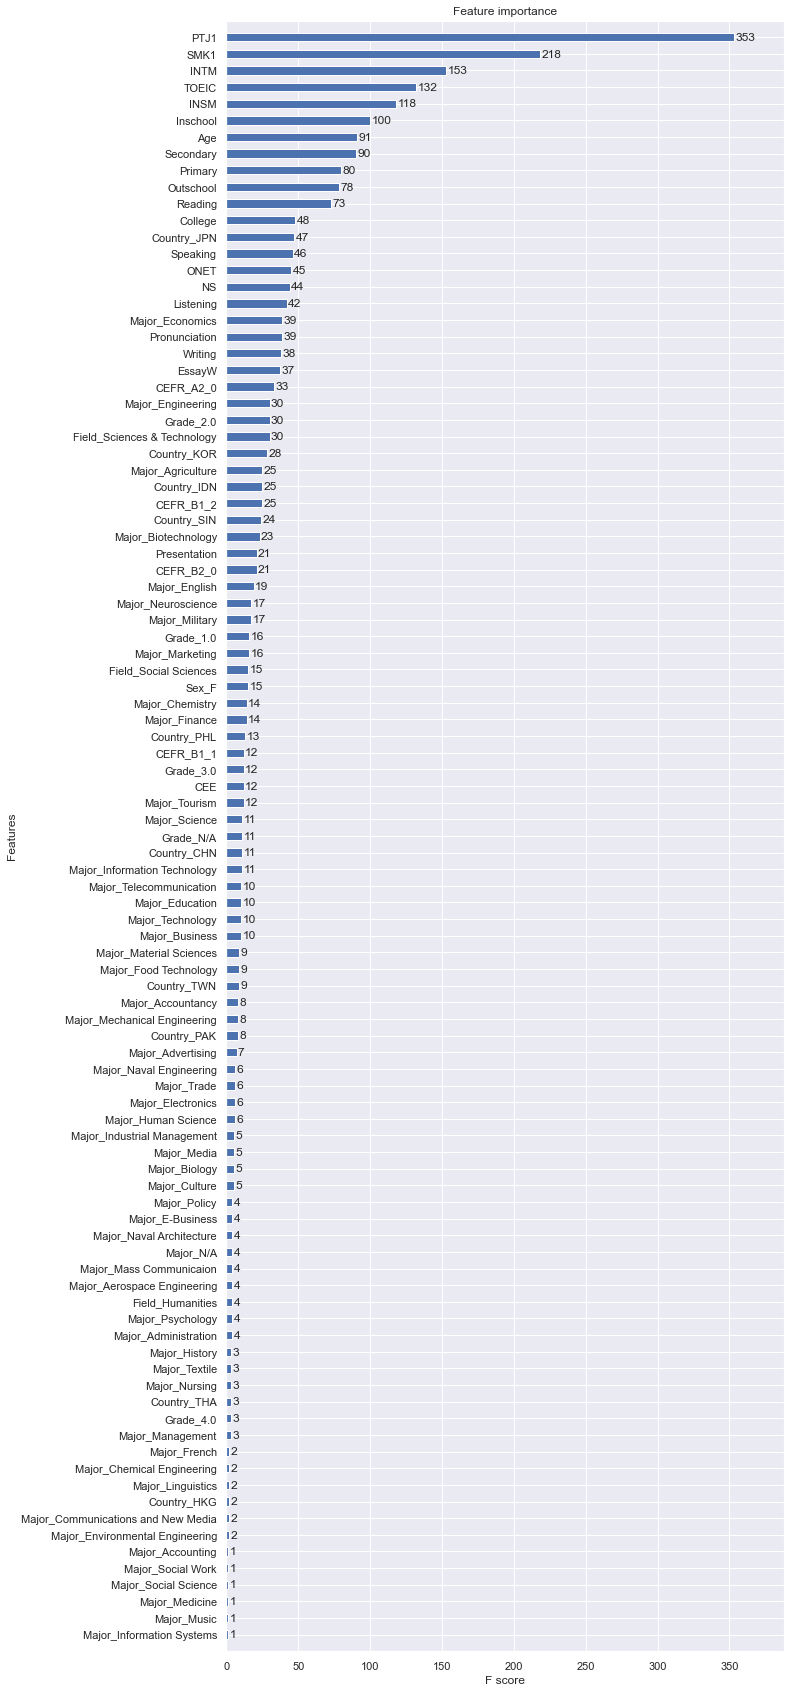

In [38]:
xg_best = xg_grid_cv.best_estimator_
xg_best.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,30))
xgb.plot_importance(xg_best, ax=ax, height=0.5)
plt.show()

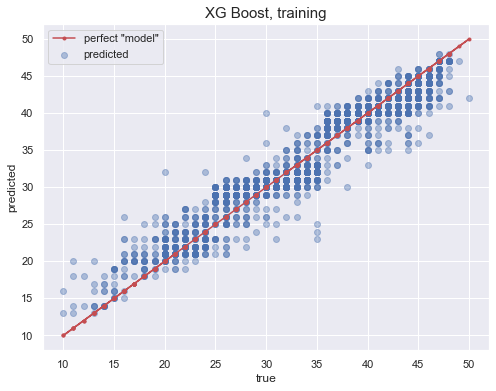

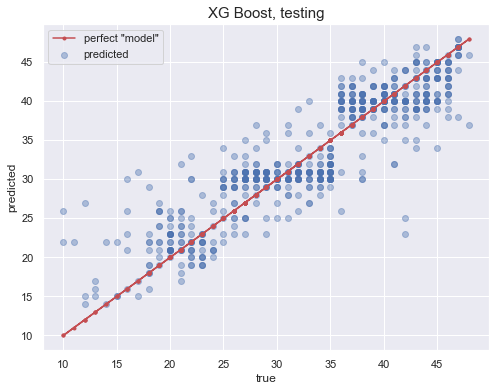

In [39]:
y_tr_xg_pred = np.round(xg_best.predict(X_train))
y_te_xg_pred = np.round(xg_best.predict(X_test))
pred_plot("XG Boost, training", y_train, y_tr_xg_pred)
pred_plot("XG Boost, testing", y_test, y_te_xg_pred)

In [40]:
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.8145489125805172
RMSE:  3.7827543892289346
